# Policy

## With Compliance

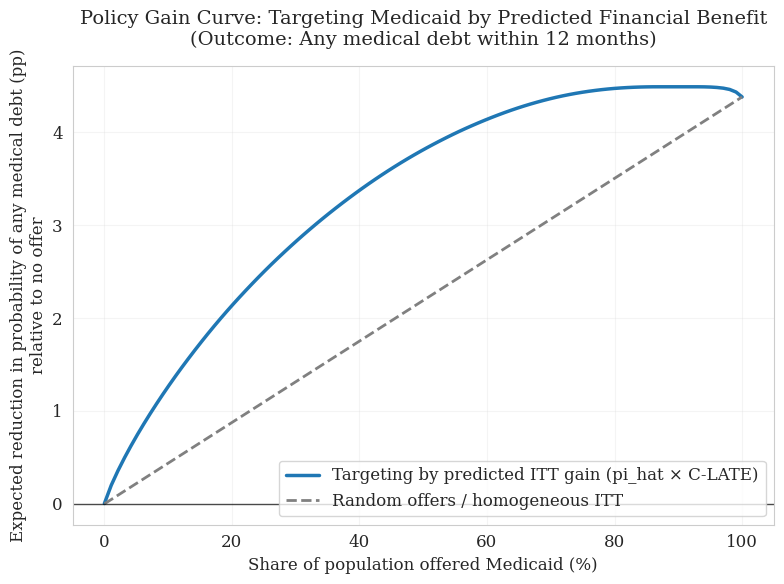

In [40]:
def plot_policy_gain_curve_any_debt(
    all_results,
    y_name="Y_cost_any_owe_12m",
    weight_col="weight_12m",
    n_points=100,
    z_col="Z_lottery",
    w_col="W_medicaid",
    risk_col="risk_index_0m",
    liquidity_col="liquidity_index_0m",
    n_bins=30,
    clip_pi_hat_at_zero=True,   # set True if you want to impose monotonicity (no defiers)
):
    """
    Policy gain curve for targeting *offers* (Z) under noncompliance.

    Uses:
      - tau_hat_i from your IV-forest (res["tau_col"])  [a C-LATE/LATE among compliers]
      - pi_hat(cell) = E[W|Z=1,cell] - E[W|Z=0,cell]    [conditional first stage]
    Targeting score:
      - ITT_hat_i = pi_hat(cell_i) * tau_hat_i
      - benefit_pp = -(ITT_hat_i) * 100  (positive = reduction in debt probability per offer)

    This is an in-sample policy-gain curve (descriptive).
    """

    # Pull already-estimated forest outputs (no re-estimation happens here)
    res = all_results[y_name]
    df = res["df_y"].copy()
    tau_col = res["tau_col"]

    # Clean sample (np.average requires positive total weights)
    df = df.dropna(subset=[tau_col, weight_col, z_col, w_col, risk_col, liquidity_col]).copy()
    df = df.loc[df[weight_col] > 0].copy()

    # Ensure Z is binary 0/1
    df[z_col] = df[z_col].astype(int)

    # Estimate conditional first stage pi_hat via (risk_bin, liq_bin)
    df["risk_bin"] = pd.qcut(df[risk_col], q=n_bins, labels=False, duplicates="drop")
    df["liq_bin"]  = pd.qcut(df[liquidity_col], q=n_bins, labels=False, duplicates="drop")

    cell_means = (
        df.groupby(["risk_bin", "liq_bin", z_col], sort=False)
          .apply(lambda g: np.average(g[w_col], weights=g[weight_col]))
          .rename("wmean_W")
          .reset_index())

    cell_piv = cell_means.pivot_table(
        index=["risk_bin", "liq_bin"],
        columns=z_col,
        values="wmean_W",
        aggfunc="first",)

    # Guarantee both columns exist before differencing
    if 0 not in cell_piv.columns:
        cell_piv[0] = np.nan
    if 1 not in cell_piv.columns:
        cell_piv[1] = np.nan

    cell_piv["pi_hat"] = cell_piv[1] - cell_piv[0]
    cell_piv = cell_piv[["pi_hat"]].reset_index()

    # Merge pi_hat back (many-to-one)
    df = df.merge(cell_piv, on=["risk_bin", "liq_bin"], how="left")

    # Overall weighted first stage fallback
    fs1 = np.average(df.loc[df[z_col] == 1, w_col], weights=df.loc[df[z_col] == 1, weight_col])
    fs0 = np.average(df.loc[df[z_col] == 0, w_col], weights=df.loc[df[z_col] == 0, weight_col])
    pi_overall = fs1 - fs0
    df["pi_hat"] = df["pi_hat"].fillna(pi_overall)

    if clip_pi_hat_at_zero:
        df["pi_hat"] = df["pi_hat"].clip(lower=0.0)

    # Weights AFTER merge (alignment guaranteed)
    w = df[weight_col].to_numpy(dtype=float)
    w_total = w.sum()
    if not np.isfinite(w_total) or w_total <= 0:
        raise ValueError("Total weight is non-positive or non-finite after cleaning.")

    # Predicted ITT gain from offers
    tau_hat = df[tau_col].to_numpy(dtype=float)                     
    itt_hat = df["pi_hat"].to_numpy(dtype=float) * tau_hat          
    benefit_pp = -itt_hat * 100.0                                   

    # Sort by predicted benefit
    order = np.argsort(-benefit_pp)
    benefit_pp_sorted = benefit_pp[order]
    w_sorted = w[order]

    # Policy gain curve (per-capita, weighted)
    w_cum = np.cumsum(w_sorted)
    share = w_cum / w_total
    cum_benefit_per_capita_pp = np.cumsum(benefit_pp_sorted * w_sorted) / w_total

    # Benchmark: random offers / homogeneous ITT
    mean_benefit_pp = np.sum(benefit_pp * w) / w_total
    benchmark_gain_pp = share * mean_benefit_pp

    # Downsample for plotting (force last point included)
    if len(share) > n_points:
        idx = np.unique(np.r_[np.linspace(0, len(share) - 1, n_points).astype(int), len(share) - 1])
        share_plot = share[idx]
        gain_plot = cum_benefit_per_capita_pp[idx]
        bench_plot = benchmark_gain_pp[idx]
    else:
        share_plot = share
        gain_plot = cum_benefit_per_capita_pp
        bench_plot = benchmark_gain_pp

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(share_plot * 100, gain_plot, label="Targeting by predicted ITT gain (pi_hat × C-LATE)", linewidth=2.5)
    plt.plot(share_plot * 100, bench_plot, linestyle="--", color="gray",
             label="Random offers / homogeneous ITT", linewidth=2)
    plt.axhline(0, color="black", linewidth=1, alpha=0.7)
    plt.xlabel("Share of population offered Medicaid (%)", fontsize=12)
    plt.ylabel("Expected reduction in probability of any medical debt (pp)\nrelative to no offer", fontsize=12)
    plt.title("Policy Gain Curve: Targeting Medicaid by Predicted Financial Benefit\n"
              "(Outcome: Any medical debt within 12 months)", fontsize=14, pad=15)
    plt.legend(frameon=True)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig("../Output/fig_policy_with_compliance.png", dpi=300, bbox_inches="tight")  
    plt.show()

    return pd.DataFrame({
        "share_pop": share,
        "cum_benefit_pp": cum_benefit_per_capita_pp,
        "benchmark_pp": benchmark_gain_pp,
    })
gain_df_any_debt = plot_policy_gain_curve_any_debt(all_results)